# Prior Modelling and prior predictive checks

### Marcel Lüthi, Departement Mathematics and Computer Science, University of Basel 

### Setup

Before we start we set up the necessary libraries and instruct the scala kernel to be less verbose. 

In [3]:
// Suppressing excessive output for the jupyter-notebook
val api = implicitly[almond.api.JupyterApi]
api.silent(true)

api: JupyterApi = almond.JupyterApiImpl@513b32ab

In [4]:
// add a repository from which the libraries are loaded
import coursierapi.{Credentials, MavenRepository}
interp.repositories() ++= Seq(
  MavenRepository.of("https://oss.sonatype.org/content/repositories/snapshots")
)

In [5]:
// load the necessary libraries
import $ivy.`ch.unibas.cs.gravis::scalismo-plot:0.1-SNAPSHOT`
import $ivy.`org.scalanlp::breeze:2.1.0`
import $ivy.`org.scalanlp::breeze-natives:2.1.0`

In order not to pollute the code below with unnecessary import statements, we import all the functionality that is needed right at the start. 

In [6]:
// plotting functionality
import scalismo.plot.data.DataFrame
import scalismo.plot.plottarget.PlotTarget.plotTargetJupyter

// linear algebra library
import breeze.linalg.{DenseMatrix, DenseVector, linspace}
import breeze.stats.distributions.*
import breeze.stats.distributions.Rand.FixedSeed.randBasis

// misc tools from java
import java.io.File
import java.lang.Math

### Loading the hand data

We start by loading the data for our toy problem from a csv file:

In [7]:
val data = DataFrame.fromCSV(File("./data/hand-measurements.csv")).get

The data is organized as a data frame. The following code prints the number of rows and lists the first 5 rows of the data frame:


In [8]:
println("number of rows: " + data.numberOfRows)
println(data(rows = 0 until 5))

number of rows: 233
+------+----+
|Length|Span|
+------+----+
|  17.3|  20|
|    18|19.5|
|  18.5|  20|
|    19|20.6|
|  19.5|  22|


We see how the data consists of the columns `Length` and `Span`.

At the moment, we do not look at the data in more detail, in order to avoid that we specificly tailor the model to this particular dataset 
instead of modelling more generally what we believe about the process that generated the data to be true. 

### A first Bayesian model 

We start by devising a model for the length of a hand. It is well known that data that originate from natural growth processes often follow a normal distribution:

$
l \sim N(\mu, \sigma)
$

Although we do not know the values of the parameters $\mu$ and $\sigma$ we have some idea. For example, we know that the length is a positive number and that no hand is larger than, say, 50 mm. Also we know that the standard deviation $\sigma$ is a positive number and surely smaller 20. We can encode this information as probability distribution:

In [9]:
val dMuLength = Gaussian(20, 10)
val dSigma = Uniform(0, 5)

Specifying the uncertainty over parameters as distribution leads naturally to a Bayesian model. It effectively implies that we model the joint distribution $p(l, \mu, \sigma)$ instead of the marginal distribution $p(l)$. While this may seem complicated at first, it turns out that both sampling from the joint distribution $p(l, \mu, \sigma,)$ and obtaining samples from the marginal distribution $p(l)$ is easily possible. 

To draw samples from the joint distribution, we decompose it using the chain rule:
$
p(l, \mu, \sigma) = p(l | \mu, \sigma) p(\mu) p(\sigma)
$

This is a very typical decomposition in Bayesian modelling. The term $p(l | \mu, \sigma)$ involving the data is called the 
*likelihood* whereas the terms $p(\mu)$ and $p(\sigma)$ are called the prior. 


Thanks to this decomposition, and because all the distributions involved are easy to sample from individually, we can generate samples from the joint distribution. We draw a sample from $p(\mu)$ and one from $p(\mu)$ and use these samples to draw from $p(l| \mu, \sigma)$. 



The following code implements the generation process:

In [10]:
// A helper class represenging samples from the random variables
case class Sample(l : Double, mu : Double, sigma : Double) 

def generate(nExamples : Int) : Seq[Sample] = 
    for i <- 0 until nExamples yield

        // prior
        val mu = dMuLength.draw()
        val sigma = dSigma.draw()

        // likelihood
        val h = Gaussian(mu, sigma).draw()
        Sample(h, mu, sigma)

Let's try it out:

In [11]:
val samples = generate(10)
println(samples)

Vector(Sample(11.449167202612298,12.194205359150587,3.013816912319184), Sample(6.233851024416713,7.4117098567545465,3.229470579652615), Sample(16.458400397852515,15.57702620333938,4.818313812662385), Sample(16.1264099441004,14.917987173351273,2.644474616645065), Sample(16.363693475446034,16.421604569183753,0.3551803035584211), Sample(49.903257207426336,43.85042154924961,4.163099226143595), Sample(18.38684733309504,20.928761317299813,4.893091728807094), Sample(19.15667052886257,23.780468488495266,3.9026459067225105), Sample(27.415930790291036,26.957689604204376,0.7167664570639443), Sample(29.9171381586465,30.72275266649261,2.0733096803427054))


#### Exercise:

* Think about whether you agree with our choice of distribution. How would you choose them? How is the uncertainty reflected in the distribution?
* Change the distribution to something you find reasonable. You may also want to check the internet for known facts about the shape of the hand.

### Prior predictive checks

Now that we have thought about possible distributions for the priors, we would like to assess the consequence of our choice. This can be done by visualizing the samples and by computing different point-estimates. 

Let's start by drawing many samples and visualizing a histogram of the parameters:

In [13]:
val generatedData = generate(10000)
val dataFrame = DataFrame(Seq(
    DataFrame.Column.ofContinuous(generatedData.map(sample => sample.mu), name = "mu"),
    DataFrame.Column.ofContinuous(generatedData.map(sample => sample.sigma), name = "sigma"),
    DataFrame.Column.ofContinuous(generatedData.map(sample => sample.l), name = "length")
    )
 )


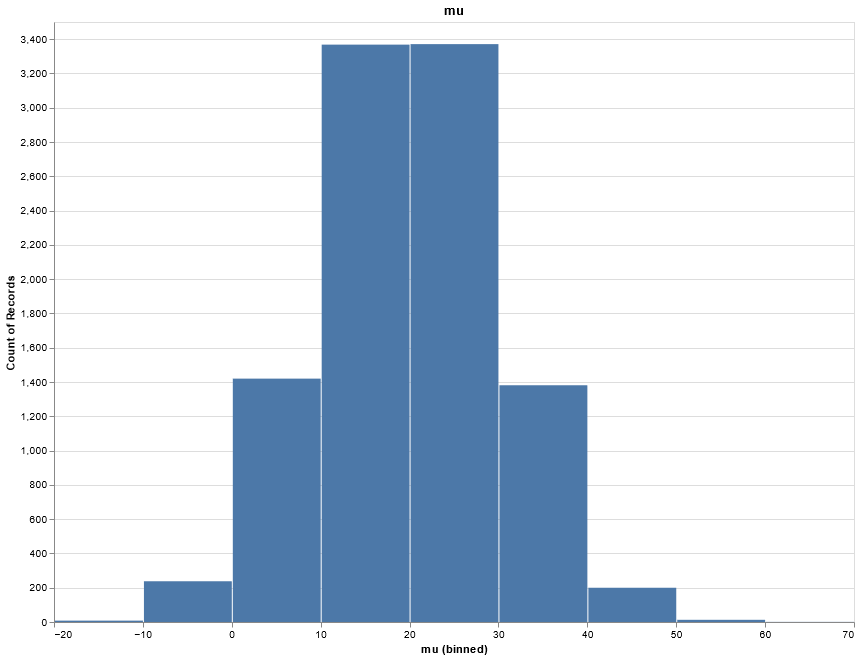

In [14]:
dataFrame.plot.histogram("mu", title = "mu").show()

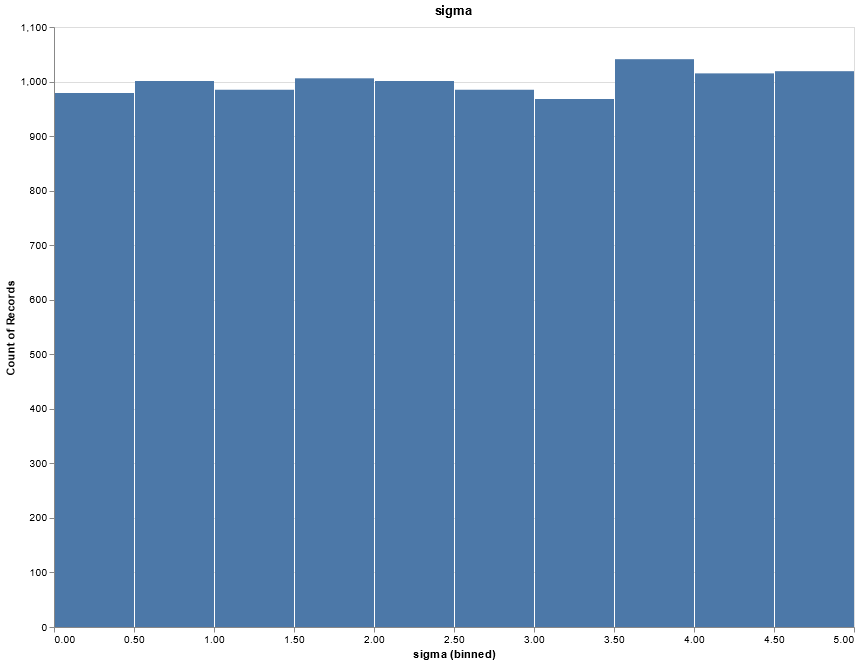

In [37]:
dataFrame.plot.histogram("sigma", title = "sigma").show()

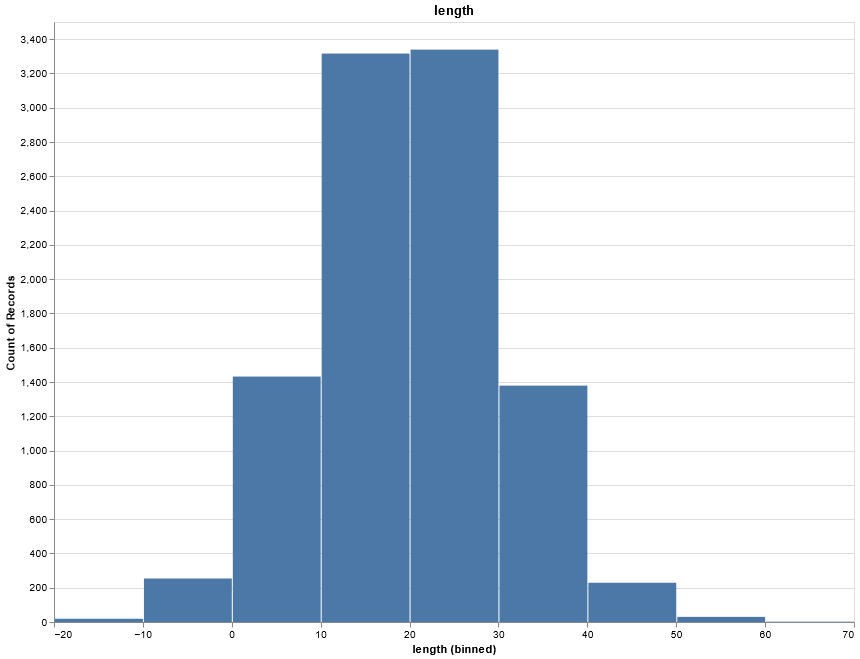

In [38]:
dataFrame.plot.histogram("length", title = "length").show()

#### Exercise:
* What can you infer from this plot? Was this a good choice of prior distribution?
* Experiment with different parameters for the prior distributions. Which parameters are reasonable, which are not?
* Can you think of other quantities that you could estimate from the samples that would tell you if the prior is reasonable? Try to implement them. 


### Bayesian regression 

Modelling only one variable is pretty lame. Instead, we would like to devise a model involving both the length and the span. 

We know that there is a relationship between the variables in our problems. The span of the hand clearly depends on the length. Larger hands have a larger span. That means we can add this structure to the model and also use the length to predict the span. This observation leads us to a regression model.

To go from our simple model of one variable to a regression method, we treat the mean $\mu$  not as a parameter, but as a function $\mu = a \cdot \text{span} + b$, where $a$ and $b$ are again parameter. This means that our model becomes:

$$
\text{length} \sim N(a \cdot \text{span} + b, \sigma )
$$

To devise a Bayesian model, we follow exactly the same approach as above and define a prior distribution for all the parameters. 


#### Exercises:

Your task is now to repeat the steps above for the regression model. In particular:

* Choose appropriate priors for the parameters $a$, $b$ and $\sigma$. 
* Write a function to generate data for this new model.
* Generate samples and use them to visualize the data. You can use histograms as above, scatterplots, but also plot the functions themselves. You find some code snippets that may be helpful below.

#### Hints for the exercises

In [50]:
Scatterplots can be created as follows:

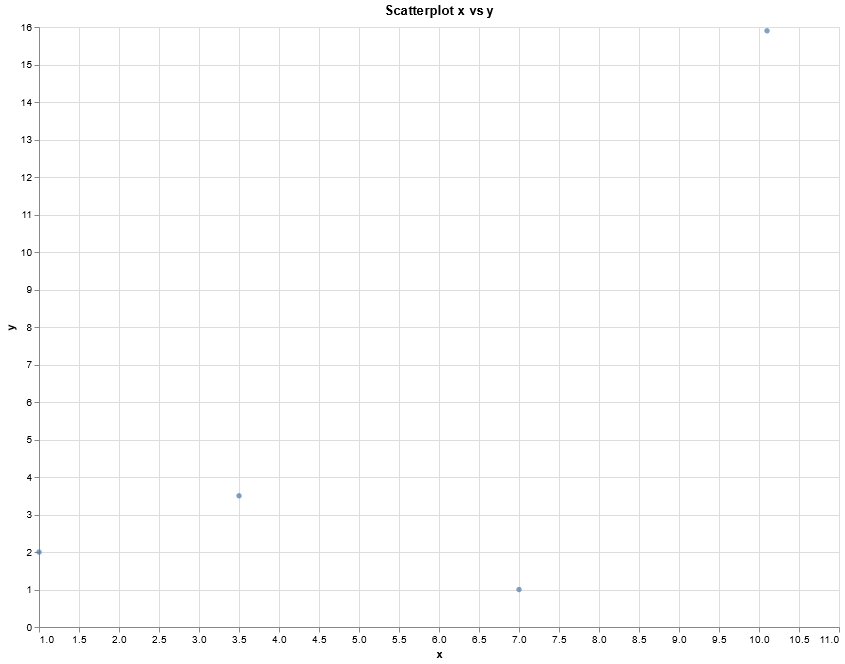

In [50]:
// Create data frame with the values
val dataFrame = DataFrame.fromColumns(Seq(
    DataFrame.Column.ofContinuous(Seq(1.0, 3.5, 7.0, 10.1), "x" ),
    DataFrame.Column.ofContinuous(Seq(2.0, 3.5, 1.0, 15.9), "y" ),
    )
)

// do the scatterplot
dataFrame.plot.scatterPlot("x" , "y", title="Scatterplot x vs y" ).show()

To visualize a function, we can use the following Code:

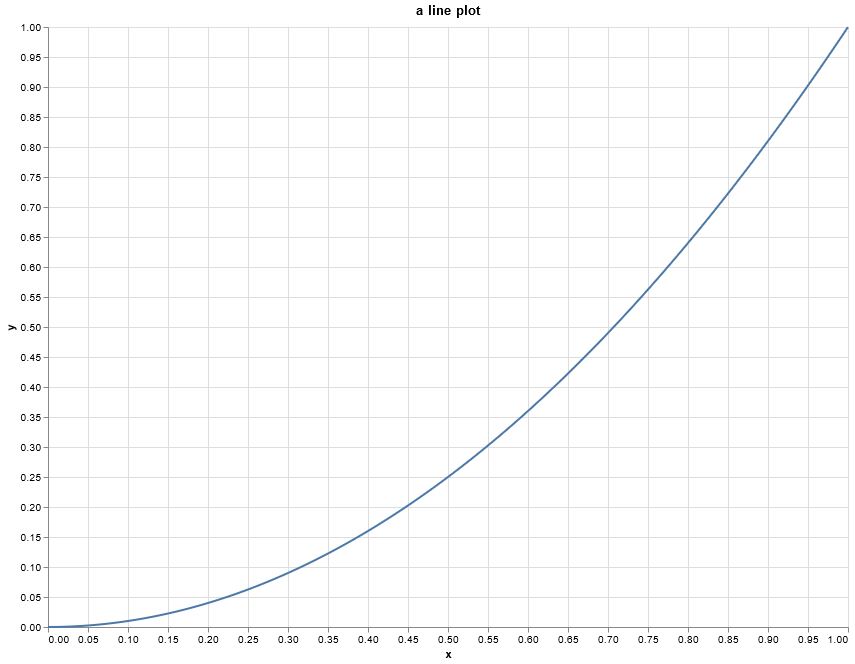

In [45]:
// defining the function
def f(x : Double) = x * x

// create values for the x-axis
val xs = linspace(0, 1, 100).toScalaVector

// create a dataframe and choose the appropriate columns to plot the data
DataFrame.fromFunction(f, xs).plot.linePlot(x = "x", y = "y", title = "a line plot").show()

A series of functions can be visualized as follows:

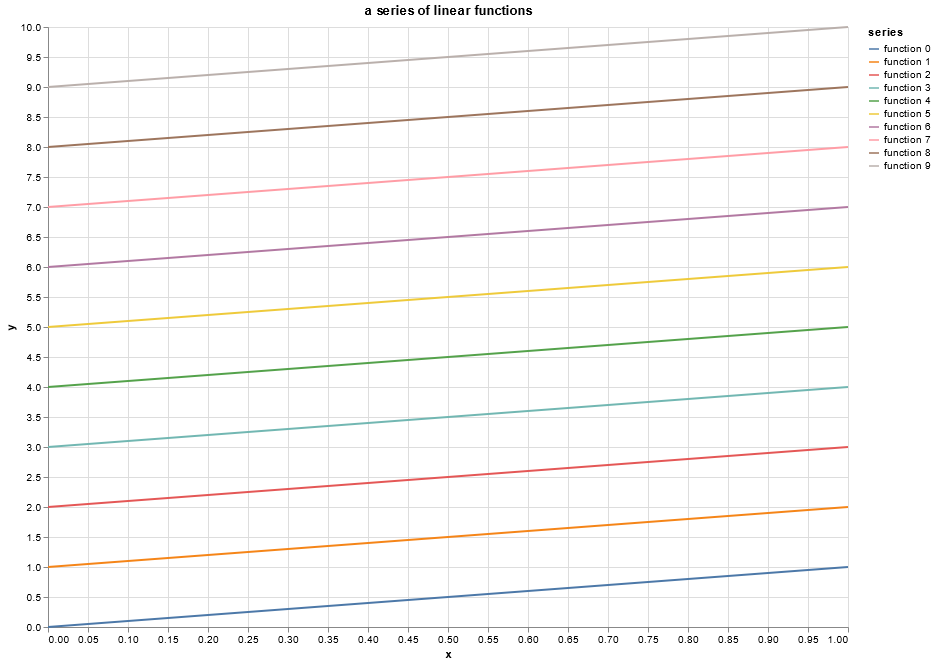

In [16]:
// the values on the x-axis
val xs = linspace(0, 1, 100).toScalaVector

// we create for each line that we would like to plot a separate data frame, 
// consisting of a column x and y with the x and y values, and a name for the series
val dataFrames = for i <- 0 until 10 yield 
    
    val fun = (x : Double) => x + i // the function
    DataFrame.fromColumns(
        Seq(
            DataFrame.Column.ofContinuous(xs, "x"),
            DataFrame.Column.ofContinuous(xs.map(x => fun(x)), "y"),
            DataFrame.Column.ofNominals(Seq.fill(xs.length)(s"function $i"), name = "series")
        )
    )

// we concatenate all the dataframes into one
val combinedDataFrameForSeries = dataFrames.reduce((acc, x) => acc.concat(x))

// we use the new data frame to plot the series
combinedDataFrameForSeries.plot.linePlot(x = "x", y = "y", series = "series", title="a series of linear functions").show() 


### Visualizing the data

As mentioned earlier, it is best not to look at the data before having done the inference. This avoids that we tune our priors to characteristics of the particular dataset at hand and forces us to model general facts that are known in the world. 

Nevertheless, we allow ourselves now a peak at the data. 

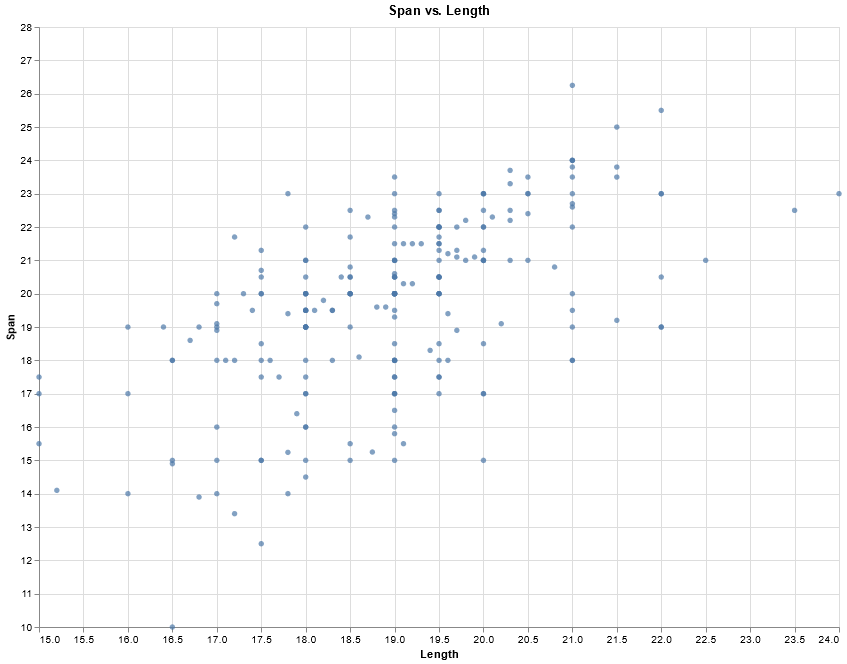

In [17]:
val scatter = data.plot.scatterPlot(x  = "Length", y = "Span", title = "Span vs. Length")
scatter.show()

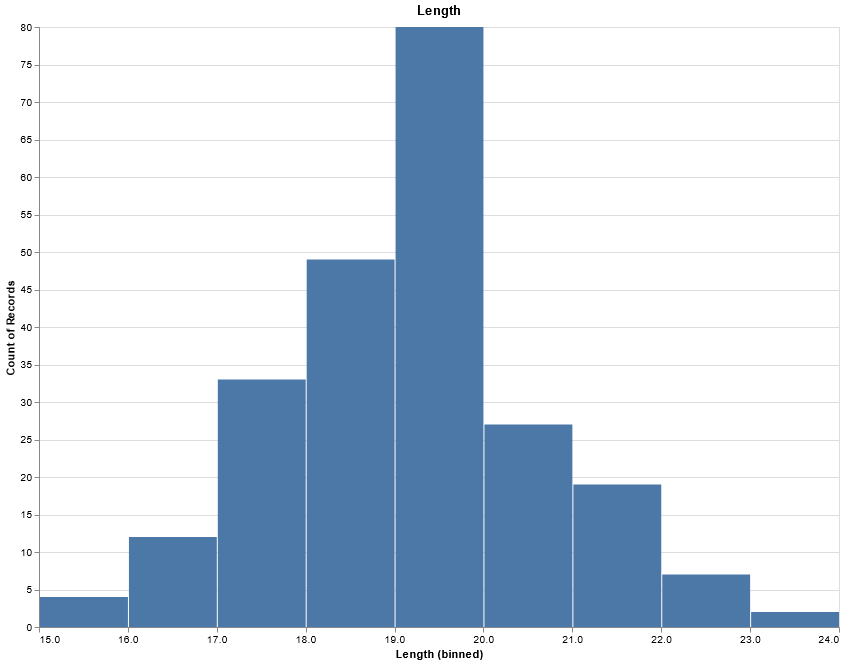

In [18]:
val histogramLength = data.plot.histogram("Length", title = "Length")
histogramLength.show()

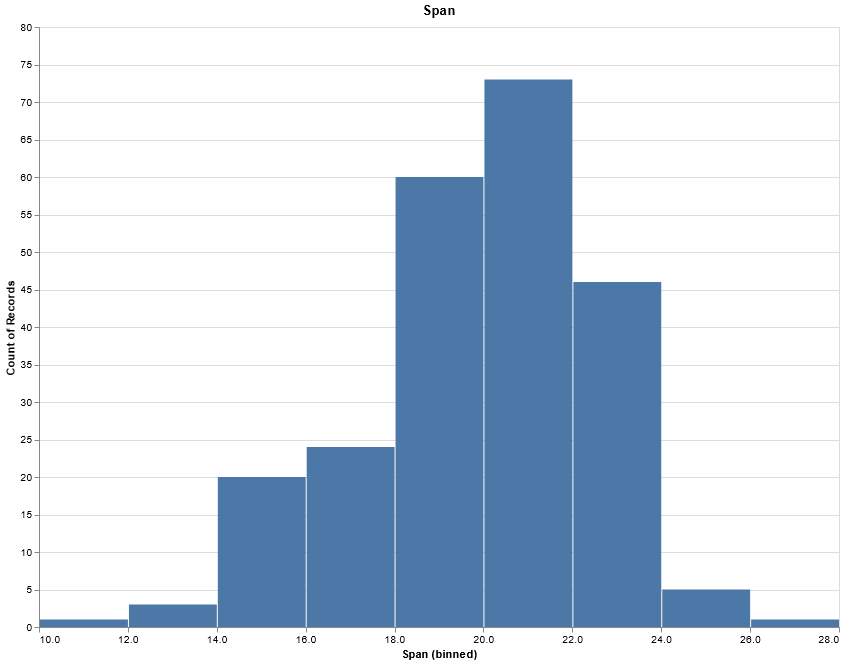

In [19]:
val histogramSpan = data.plot.histogram("Span", title = "Span")
histogramSpan.show()

### Exercise:

Think about the following:


* Do you think the priors that you chose would allow to represent this data? Is it too restrictive or too loose?
* Is it better that  a prior is too loose or too restrictive? Why?